# Toxic Comment Classification

Group Project for MSDS621 Machine Learning at University of San Francisco. Kaggle competition link: https://www.kaggle.com/c/jigsaw-toxic-comment-classification-challenge

Team members include:
1. Xinran (Grace) Zhang
2. Shivee Singh
3. Neha Tevathia
4. Tianqi Wang
5. Meng-Ting(Joyce) Chang

## Overview

The project aims to build a multi-headed model that’s capable of detecting different types of of toxicity like threats, obscenity, insults, and identity-based hate, we will use a dataset of comments from Wikipedia’s talk page edits, collected by Kaggle. Improvements to the current model will hopefully help online discussion become more productive and respectful.

### Metrics

There are six labels, the results are evaluated on the mean column-wise ROC AUC. In other words, the score is the average of the individual AUCs of each predicted column. So the performance metrics for the model is AUC of each label.

##### Packages Load

In [1]:
# Packages for data processing and wrangling
import pandas as pd
import numpy as np
import re
import string
from sklearn.metrics import confusion_matrix

# Packages for visulization
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.offline as py 
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go

# Packages for feature engineering
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_selection import chi2
from nltk.stem.wordnet import WordNetLemmatizer
from sklearn.pipeline import Pipeline

# Packages for modeling
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score

# ignore warnings
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

## Load Data

##### Data Load

In [2]:
train = pd.read_csv('./data/train.csv')
test_X = pd.read_csv('./data/test.csv')
test_y = pd.read_csv('./data/test_labels.csv')
submission = pd.read_csv('./data/sample_submission.csv')

##### Data Glimpse

Firstly we can take a look at training data.

In [3]:
train.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


In [4]:
train.shape

(159571, 8)

In training data, we have 159571 observations, for each observation, there is one unique id, and the predictor variable is the **comment_text**. The predicted variables are 6 labels that could show some toxic charateristics of the comment.

In [5]:
test_X.head()

,id,comment_text
0,00001cee341fdb12,Yo bitch Ja Rule is more succesful then you'll...
1,0000247867823ef7,== From RfC == \n\n The title is fine as it is...
2,00013b17ad220c46,""" \n\n == Sources == \n\n * Zawe Ashton on Lap..."
3,00017563c3f7919a,":If you have a look back at the source, the in..."
4,00017695ad8997eb,I don't anonymously edit articles at all.


In [6]:
train.describe()

,toxic,severe_toxic,obscene,threat,insult,identity_hate
count,159571.000000,159571.000000,159571.000000,159571.000000,159571.000000,159571.000000
mean,0.095844,0.009996,0.052948,0.002996,0.049364,0.008805
std,0.294379,0.099477,0.223931,0.054650,0.216627,0.093420
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [7]:
test_y.head()

,id,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,00001cee341fdb12,-1,-1,-1,-1,-1,-1
1,0000247867823ef7,-1,-1,-1,-1,-1,-1
2,00013b17ad220c46,-1,-1,-1,-1,-1,-1
3,00017563c3f7919a,-1,-1,-1,-1,-1,-1
4,00017695ad8997eb,-1,-1,-1,-1,-1,-1


In [8]:
submission.head()

,id,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,00001cee341fdb12,0.5,0.5,0.5,0.5,0.5,0.5
1,0000247867823ef7,0.5,0.5,0.5,0.5,0.5,0.5
2,00013b17ad220c46,0.5,0.5,0.5,0.5,0.5,0.5
3,00017563c3f7919a,0.5,0.5,0.5,0.5,0.5,0.5
4,00017695ad8997eb,0.5,0.5,0.5,0.5,0.5,0.5


In [9]:
train.shape
test_X.shape

(153164, 2)

## Explanatory Data Analysis

We first check the predicted variable **Comment**.

In [10]:
train['comment_text'][0]

"Explanation\nWhy the edits made under my username Hardcore Metallica Fan were reverted? They weren't vandalisms, just closure on some GAs after I voted at New York Dolls FAC. And please don't remove the template from the talk page since I'm retired now.89.205.38.27"

Check the length distribution of the comment.

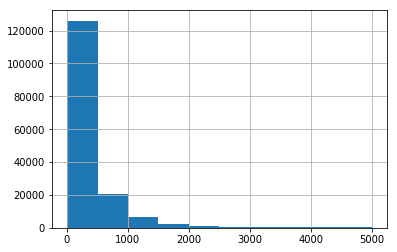

In [11]:
lens = train.comment_text.str.len()
lens.hist()

In [12]:
train_num = train.shape[0]
test_num = test_X.shape[0]
print(f"There are {train_num} training comments and {test_num} test comments.")

There are 159571 training comments and 153164 test comments.


In [13]:
comment_distr = train.iloc[:,2:].sum()
comment_distr

toxic            15294
severe_toxic      1595
obscene           8449
threat             478
insult            7877
identity_hate     1405
dtype: int64

In [14]:
rowsums = train.iloc[:,2:].sum(axis=1)

In [15]:
train['non_toxic'] = (rowsums == 0)

In [16]:
comment_non_toxic = train['non_toxic'].sum()
print(f"There are {comment_non_toxic} non-toxic comments in the training data set, which is {round(100*comment_non_toxic/train_num, 2)}% of the total training comments.")

There are 143346 non-toxic comments in the training data set, which is 89.83% of the total training comments.


Based on the above, we noticed that there might be class imbalance problem in this data set. Also, comments might be associated with multiple labels. For instance, the comments shown below are all associated with more than one toxiticity labels.

In [17]:
train[rowsums > 1].head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate,non_toxic
6,0002bcb3da6cb337,COCKSUCKER BEFORE YOU PISS AROUND ON MY WORK,1,1,1,0,1,0,False
42,001810bf8c45bf5f,You are gay or antisemmitian? \n\nArchangel WH...,1,0,1,0,1,1,False
43,00190820581d90ce,"FUCK YOUR FILTHY MOTHER IN THE ASS, DRY!",1,0,1,0,1,0,False
51,001dc38a83d420cf,GET FUCKED UP. GET FUCKEEED UP. GOT A DRINK T...,1,0,1,0,0,0,False
55,0020e7119b96eeeb,Stupid peace of shit stop deleting my stuff as...,1,1,1,0,1,0,False


It might be a great practice to see which labels are likely to appear together with a comment.

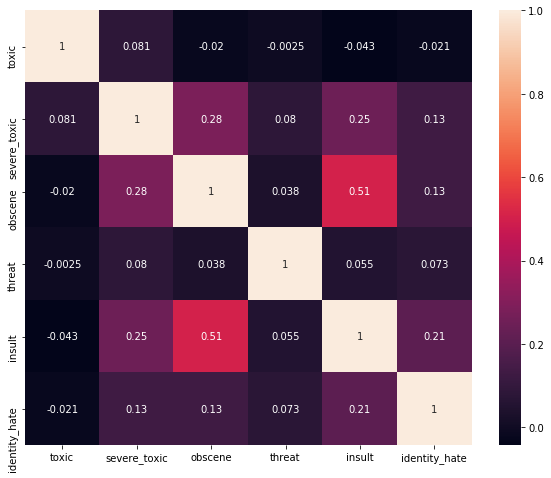

In [18]:
temp = train.iloc[:,2:-1]
train_corr = temp[rowsums > 0]
corr = train_corr.corr()
plt.figure(figsize=(10,8))
sns.heatmap(corr,
            xticklabels=corr.columns.values,
            yticklabels=corr.columns.values, annot=True)

In [19]:
confusion_matrix(train["toxic"], train["severe_toxic"])

array([[144277,      0],
       [ 13699,   1595]])

In [20]:
confusion_matrix(train["toxic"], train["insult"])

array([[143744,    533],
       [  7950,   7344]])

In [21]:
confusion_matrix(train["toxic"], train["obscene"])

array([[143754,    523],
       [  7368,   7926]])

In [22]:
confusion_matrix(train["toxic"], train["threat"])

array([[144248,     29],
       [ 14845,    449]])

In [23]:
confusion_matrix(train["toxic"], train["identity_hate"])

array([[144174,    103],
       [ 13992,   1302]])

In [24]:
# comments = train['comment_text'].drop_duplicates().values.tolist()

In [25]:
# comments = [comment.split(" ") for comment in comments]

# Pre-process Data

## Feature Engineering

In [11]:
def tokenize(text):
    """
    Tokenize text and return a non-unique list of tokenized words
    found in the text. Normalize to lowercase, strip punctuation,
    remove stop words, drop words of length < 3.
    """
    from nltk.stem.porter import PorterStemmer
    #Convert everything to lowercase
    text=text.lower()
    # removed punctuation and tabs, new lines
    regex = re.compile('[' + re.escape(string.punctuation) + '0-9\\r\\t\\n]')
    nopunct = regex.sub(" ", text)
    no_username = re.sub("\[\[.*\]", "", nopunct)
    words = nopunct.split(' ')
    words = [word.encode('ascii', 'ignore').decode('ascii') for word in words]
    
    #Lemmatize words
    lmtzr = WordNetLemmatizer()
    words = [lmtzr.lemmatize(w) for w in words]
    # drop words < 2 characters long
    words=[w for w in words if len(w) > 2]
    return words

In [27]:
# Remove repetitive characters

In [12]:
# Convert comments to term-document matrix using TFIDF
vectorizer = TfidfVectorizer(ngram_range=(1,1), analyzer= 'word', tokenizer = tokenize, stop_words='english',
            strip_accents='unicode', use_idf=1, min_df=10)
X=vectorizer.fit_transform(train.comment_text)
X_test=vectorizer.transform(test_X.comment_text)
X.shape , X_test.shape

((159571, 19109), (153164, 19109))

In [13]:
vectorizer.get_feature_names()[0:40]

['aaa',
 'aap',
 'aardvark',
 'aaron',
 'aba',
 'abandon',
 'abandoned',
 'abandoning',
 'abandonment',
 'abbas',
 'abbey',
 'abbott',
 'abbreviated',
 'abbreviation',
 'abc',
 'abcnews',
 'abd',
 'abducted',
 'abduction',
 'abdul',
 'abdullah',
 'abe',
 'abel',
 'aberration',
 'abhishek',
 'abhor',
 'abhorrent',
 'abide',
 'abiding',
 'ability',
 'abit',
 'abject',
 'abkhazia',
 'able',
 'abnormal',
 'aboard',
 'abolish',
 'abolished',
 'abomination',
 'aboriginal']

Since there are six classes of predicted variables, we might need to create 6 classifiers, firstly we separate those labels.

In [14]:
train.columns

Index(['id', 'comment_text', 'toxic', 'severe_toxic', 'obscene', 'threat',
       'insult', 'identity_hate'],
      dtype='object')

In [15]:
labels = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']

# Model Fitting

Baseline Model - Logistic Regression and SVM

In [16]:
# Logistic Regression Model AUC for all labels
lr_clf = LogisticRegression()
for label in labels:
    lr_clf.fit(X, train[label])
    predicted_prob = lr_clf.predict(X_test)
    lr_auc = roc_auc_score(test_y[test_y[label]!=-1][label], predicted_prob[test_y[label]!=-1])
    print(f"The AUC Score of Logistic Regression Model for {label} is {round(lr_auc,4)}")

The AUC Score of Logistic Regression Model for toxic is 0.8348
The AUC Score of Logistic Regression Model for severe_toxic is 0.6498
The AUC Score of Logistic Regression Model for obscene is 0.7987
The AUC Score of Logistic Regression Model for threat is 0.5779
The AUC Score of Logistic Regression Model for insult is 0.7533
The AUC Score of Logistic Regression Model for identity_hate is 0.632


Then we try SVM 

In [127]:
# SVM Model AUC for all labels
svm_clf = SVC(kernel = 'linear')
for label in labels:
    svm_clf.fit(X, train[label])
    svm_predicted = svm_clf.predict(X_test)
    svm_auc = roc_auc_score(test_y[test_y[label]!=-1][label],
                        svm_predicted[test_y[label]!=-1])
    print(f"The AUC Score of SVM Model for label {label} is {round(svm_auc,4)}")

The AUC Score of SVM Model for label toxic is 0.8642
The AUC Score of SVM Model for label severe_toxic is 0.5583
The AUC Score of SVM Model for label obscene is 0.8301
The AUC Score of SVM Model for label threat is 0.5685
The AUC Score of SVM Model for label insult is 0.7858
The AUC Score of SVM Model for label identity_hate is 0.6314


In [17]:
# Using a different classifier
from sklearn import svm
svm_linear_clf = svm.LinearSVC(class_weight = {1:20})
for label in labels:
    svm_linear_clf.fit(X, train[label])
    svm_predicted = svm_linear_clf.predict(X_test)
    svm_auc = roc_auc_score(test_y[test_y[label]!=-1][label],
                        svm_predicted[test_y[label]!=-1])
    print(f"The AUC Score of SVM Model for label {label} is {round(svm_auc,4)}")

The AUC Score of SVM Model for label toxic is 0.8738
The AUC Score of SVM Model for label severe_toxic is 0.8659
The AUC Score of SVM Model for label obscene is 0.8802
The AUC Score of SVM Model for label threat is 0.7775
The AUC Score of SVM Model for label insult is 0.8556
The AUC Score of SVM Model for label identity_hate is 0.8056


In [27]:
from sklearn.naive_bayes import MultinomialNB
for label in labels:
    nb_clf = MultinomialNB()
    nb_clf.fit(X, train[label])
    nb_predicted = nb_clf.predict(X_test)
    nb_auc = roc_auc_score(test_y[test_y[label]!=-1][label],
                        nb_predicted[test_y[label]!=-1])
    print(f"The AUC Score of NB Model for label {label} is {round(nb_auc,4)}")

The AUC Score of NB Model for label toxic is 0.6131
The AUC Score of NB Model for label severe_toxic is 0.5
The AUC Score of NB Model for label obscene is 0.5698
The AUC Score of NB Model for label threat is 0.5
The AUC Score of NB Model for label insult is 0.5289
The AUC Score of NB Model for label identity_hate is 0.5


In [30]:
from sklearn.ensemble import RandomForestClassifier
for label in labels:
    rf_clf = RandomForestClassifier()
    rf_clf.fit(X, train[label])
    rf_predicted = rf_clf.predict(X_test)
    rf_auc = roc_auc_score(test_y[test_y[label]!=-1][label],
                        rf_predicted[test_y[label]!=-1])
    print(f"The AUC Score of Random Forest Model for label {label} is {round(rf_auc,4)}")

The AUC Score of Random Forest Model for label toxic is 0.8083
The AUC Score of Random Forest Model for label severe_toxic is 0.5267
The AUC Score of Random Forest Model for label obscene is 0.7796
The AUC Score of Random Forest Model for label threat is 0.5165
The AUC Score of Random Forest Model for label insult is 0.7146
The AUC Score of Random Forest Model for label identity_hate is 0.5713


In [19]:
# Model Fitting Process
# Validation - Model selection
# Pipelines/Grid Search
# Regularization?
# Ensemble (Bagging, Stacking, Boosting)

# Model Results
# Visual analysis of models (Feature importance)
# Evaluation Metrics - AUC + F Score
# Compare models to chance performance
# Present and interpret best model

# Presentation prep

In [35]:
from sklearn.model_selection import GridSearchCV

pipe_dt = Pipeline([('clf', svm.LinearSVC())])
                        
grid_params = dict(clf__tol=[1e-4, 1e-5, 1e-6],
                   clf__class_weight=[{1:10}, {1:5}])

gs = GridSearchCV(estimator=pipe_dt,  
                  param_grid=grid_params,
                  scoring='accuracy',
                  cv=10)

gs.fit(X, train["toxic"])
print(f"{gs.score(X_test, test_y):.4f}")

TypeError: '<' not supported between instances of 'int' and 'str'

### Reference

https://www.kaggle.com/jhoward/nb-svm-strong-linear-baseline
